<a href="https://colab.research.google.com/github/fabianimarco98/cinema-prediction-ML/blob/main/SC_neuralnetwork_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title
import pandas as pd
import numpy as np
import statistics  as stat
import matplotlib.pyplot as plt
from collections import Counter
import requests
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import itertools
import ast
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
drive.mount('/content/drive')

Mounted at /content/drive


Script per leggere .csv con i film presi da turni_casse

In [ ]:
# @title
%%capture
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/csv/df.csv",sep=";",encoding='unicode_escape')
# Rimuovi tutte le righe che contengono NaN
#df = df.dropna(how='any')
#sostituisce NaN con 0
df = df.fillna(0)
df['data'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y', errors='coerce')
df["giorno"] = df["data"].dt.weekday + 1
df['mese'] = df['data'].dt.month
# Rimuovi le righe in cui la colonna 'ORA' contiene NaN
df = df.dropna(subset=['ORA'])
# Applica il filtro per mantenere solo le righe in cui 'ORA' contiene ':'
#df = df[df['ORA'].str.contains(':')]
from datetime import datetime
# Supponiamo che 'ORA' sia una colonna nel tuo DataFrame con orari come '17:00' e '20:30'
df['ora'] = pd.to_datetime(df['ORA'], format='%H:%M', errors='coerce')
# Ora puoi usare .dt accessor per ottenere l'ora
df['fascia_oraria'] = df['ora'].dt.hour.apply(lambda hour: '8' if 6 <= hour < 12 else '17' if 12 <= hour < 18 else '20')
#RIMUOVE RIGHE CON -
df = df[~df.isin(['-']).any(axis=1)]
#codifica numerica
df.loc[:, 'fondo cassa finale'] = pd.to_numeric(df['FONDO CASSA FINALE'], errors='coerce')
df.loc[:, 'fondo cassa iniziale'] = pd.to_numeric(df['FONDO CASSA INIZIALE'], errors='coerce')
df.loc[:, 'incasso atteso'] = pd.to_numeric(df['INCASSO ATTESO'], errors='coerce')
df.loc[:, 'tot'] = pd.to_numeric(df['TOT'], errors='coerce')
df.loc[:, 'ridotti'] = pd.to_numeric(df['RIDOTTI'], errors='coerce')
df.loc[:, 'interi'] = pd.to_numeric(df['INTERI'], errors='coerce')
df.loc[:, 'tot'] = df.loc[:, 'interi'] + df.loc[:, 'ridotti']
# Converti la colonna 'data' in stringa formattata
df['data'] = df['data'].dt.strftime('%Y-%m-%d')

col_da_droppare=["DATA","INTERI","RIDOTTI","TOT","INCASSO ATTESO","FONDO CASSA INIZIALE","FONDO CASSA FINALE","INCASSO REALE","OMAGGIO","ORA","ora"]
df=df.drop(columns=col_da_droppare)
df.sort_values(by="data")
df.head(4)

chiamata API a TMDB per ottenere i generi dei film

In [ ]:
%%capture
#!pip install git+https://github.com/m0rp43us/openmeteopy
#!pip install meteostat
!pip install openmeteo-requests
!pip install requests-cache retry-requests

meteo chiamata api

In [ ]:
# @title
%%capture
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from tqdm import tqdm

# Configura la cache e retry
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Funzione per ottenere i dati meteo orari
def fetch_hourly_weather(latitude, longitude, start_date, end_date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ["temperature_2m", "precipitation", "cloud_cover", "sunshine_duration", "weather_code"],
        "timezone": "Europe/Rome"
    }
    try:
        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]
        hourly = response.Hourly()

        # Recupera i dati
        hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
        hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
        hourly_cloud_cover = hourly.Variables(2).ValuesAsNumpy()
        hourly_sunshine_duration = hourly.Variables(3).ValuesAsNumpy()
        hourly_weather_code = hourly.Variables(4).ValuesAsNumpy()

        hourly_data = {
            "date": pd.date_range(
                start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
                end=pd.to_datetime(hourly.TimeEnd(), unit="s", utc=True),
                freq=pd.Timedelta(seconds=hourly.Interval()),
                inclusive="left"
            ),
            "temperature_2m": hourly_temperature_2m,
            "precipitation": hourly_precipitation,
            "cloud_cover": hourly_cloud_cover,
            "sunshine_duration": hourly_sunshine_duration,
            "weather_code": hourly_weather_code,
        }
        return pd.DataFrame(hourly_data)
    except Exception as e:
        print(f"Errore nella richiesta per il periodo {start_date} - {end_date}: {e}")
        return None

# Parametri per la località
latitude = 46.0531
longitude = 11.4644

# Colonna 'data' pronta per l'API
df["data"] = pd.to_datetime(df["data"]).dt.strftime('%Y-%m-%d')
unique_dates = df["data"].unique()

# Recupera i dati meteo
all_weather_data = []
for date in tqdm(unique_dates):
    hourly_weather = fetch_hourly_weather(latitude, longitude, date, date)
    if hourly_weather is not None:
        hourly_weather["data"] = date
        all_weather_data.append(hourly_weather)

# Combina i dati
if all_weather_data:
    weather_df = pd.concat(all_weather_data, ignore_index=True)

    # Aggrega i dati orari in giornalieri
    daily_weather = weather_df.groupby("data").agg(
        temperature_mean=("temperature_2m", "mean"),
        precipitation_sum=("precipitation", "sum"),
        cloud_cover_mean=("cloud_cover", "mean"),
        sunshine_duration_sum=("sunshine_duration", "sum"),
        weather_code_mode=("weather_code", lambda x: x.mode()[0] if len(x) > 0 else None)
    ).reset_index()

    # Unisci i dati meteo con il dataframe originale
    df = df.merge(daily_weather, on="data", how="left")
    print("Dati meteo integrati con successo.")

    # Salva il risultato
    #df.to_csv("cinema_weather_data.csv", index=False)
    #print("Dati salvati in 'cinema_weather_data.csv'")
else:
    print("Nessun dato meteo disponibile.")

In [ ]:
df.columns

Index(['TITOLO', 'data', 'giorno', 'mese', 'fascia_oraria',
       'fondo cassa finale', 'fondo cassa iniziale', 'incasso atteso', 'tot',
       'ridotti', 'interi', 'temperature_mean', 'precipitation_sum',
       'cloud_cover_mean', 'sunshine_duration_sum', 'weather_code_mode'],
      dtype='object')

In [ ]:
# @title
"ottengo generi e altri dati via API per i film --> non eseguire sempre"

def get_genre_ids(df):
    api_key = ""  # tMDb API key
    generi = []  # Lista per memorizzare i generi
    lingue=[]
    popolarità=[]
    rating=[]
    id=[]
    #overview=[]
    for index, row in tqdm(df.iterrows()):
        movie_title = row["TITOLO"]
        if movie_title.endswith(" - Piacere del Cinema"):
            movie_title=movie_title[:-21]
        url = "https://api.themoviedb.org/3/search/movie"
        params = {
            'api_key': api_key,
            'query': movie_title,
            'language': 'it-IT',  # Imposta la lingua italiana
        }
        response = requests.get(url, params=params) #timeout=250
        if response.status_code == 200:
            movie_data = response.json()
            #print([genere["genre_ids"] for genere in movie_data["results"]])

            # Controlla se ci sono generi disponibili
            if movie_data["results"]: #è una lista
                #print(movie_data["results"])
                #genre_ids = [genere["genre_ids"] for genere in movie_data["results"]]
                genre_ids = movie_data["results"][0]["genre_ids"] #prende solo la prima lista di generi
                generi.append(genre_ids)
                lingua=movie_data["results"][0]["original_language"]
                lingue.append(lingua)
                popolarità_singola=movie_data["results"][0]["popularity"]
                popolarità.append(popolarità_singola)
                rating_singolo=movie_data["results"][0]["vote_average"]
                rating.append(rating_singolo)
                id_singolo=movie_data["results"][0]["id"]
                id.append(id_singolo)
                #overview_singola=movie_data["results"][0]["overview"]
                #overview.append(overview_singola)
            else:
                generi.append([])  # Nessun genere disponibile per questo film
                lingue.append([])
                popolarità.append([])
                rating.append([])
                id.append([])
                #overview.append([])
        else:
            print(f"Error: {response.status_code}")
            print(response.text)
            generi.append([])  # Nessuna risposta positiva per questo film
            lingue.append([])
            popolarità.append([])
            rating.append([])
            id.append([])
            #overview.append([])
    # Aggiungi una colonna al DataFrame con gli ID dei generi
    df["genre_ids"] = generi
    df["original_language"]=lingue
    df['popularity']=popolarità
    df["rating"]=rating
    df["id"]=id
    #df['overview']=overview
    df = df[df['genre_ids'].apply(lambda x: len(x) > 0)]  # Rimuovi le righe con liste vuote
    df = df[df['original_language'].apply(lambda x: len(x) > 0)]
    return df

colonneselezionate = ['TITOLO', 'mese','tot','giorno','fascia_oraria', 'temperature_mean_x','precipitation_sum_x','sunshine_duration_sum_x','weather_code_mode_x']
'''
['TITOLO', 'data', 'giorno', 'mese', 'fascia_oraria',
       'fondo cassa finale', 'fondo cassa iniziale', 'incasso atteso', 'tot',
       'ridotti', 'interi', 'temperature_mean_x', 'precipitation_sum_x',
       'cloud_cover_mean_x', 'sunshine_duration_sum_x', 'weather_code_mode_x',
       'temperature_mean_y', 'precipitation_sum_y', 'cloud_cover_mean_y',
       'sunshine_duration_sum_y', 'weather_code_mode_y']
'''
df_titoli = df.loc[:, colonneselezionate].copy()
df2=get_genre_ids(df_titoli)
df2

KeyError: "['temperature_mean_x', 'precipitation_sum_x', 'sunshine_duration_sum_x', 'weather_code_mode_x'] not in index"

In [ ]:
# Funzione per ottenere i dettagli del film e aggiornare il DataFrame
def get_movie_details(df):
    api_key = ""  # TMDb API key
    cast_list = []
    director_list = []
    budget_list = []
    production_list = []
    keyword_list = []
    belongs_to_collection_list=[]

    for index, row in tqdm(df.iterrows()):
        movie_title = row["TITOLO"]
        tmdb_id = row["id"]
        if movie_title.endswith(" - Piacere del Cinema"):
            movie_title = movie_title[:-21]

        # Ottenere i crediti del film
        url_credits = f'https://api.themoviedb.org/3/movie/{tmdb_id}/credits'
        params = {
            'api_key': api_key,
            'language': 'it-IT',  # Imposta la lingua italiana
        }
        response_credits = requests.get(url_credits, params=params)

        if response_credits.status_code == 200:
            data_credits = response_credits.json()
            cast = [member['name'] for member in data_credits['cast'][:1]]  # primi 5 attori
            director = [member['name'] for member in data_credits['crew'] if member['job'] == 'Director']
            cast_list.append(cast)
            director_list.append(director[0] if director else None)
        else:
            cast_list.append([])
            director_list.append(None)

        # Ottenere i dettagli del film
        url_details = f'https://api.themoviedb.org/3/movie/{tmdb_id}'
        response_details = requests.get(url_details, params=params)

        if response_details.status_code == 200:
            data_details = response_details.json()
            budget = data_details.get('budget', None)
            budget_list.append(budget)
            production_companies = data_details.get('production_companies', [])
            first_production_company = production_companies[0]['name'] if production_companies else None
            production_list.append(first_production_company)
            belongs_to_collection=data_details.get("belongs_to_collection",None)
            belongs_to_collection_list.append(belongs_to_collection)
        else:
            budget_list.append(None)
            production_list.append([])
            belongs_to_collection_list.append(None)

        # Ottenere le keyword del film
        url_keywords = f'https://api.themoviedb.org/3/movie/{tmdb_id}/keywords'
        response_keywords = requests.get(url_keywords, params=params)

        if response_keywords.status_code == 200:
            data_keywords = response_keywords.json()
            keywords = [keyword['name'] for keyword in data_keywords.get('keywords', [])]
            keyword_list.append(keywords)
        else:
            keyword_list.append([])

    df['cast'] = cast_list
    df['director'] = director_list
    df['budget'] = budget_list
    df['production_company'] = production_list
    df['keywords'] = keyword_list
    df["belongs_to_collection"]=belongs_to_collection_list
    return df

# Esegui la funzione
df2 = get_movie_details(df2)

# Funzione per estrarre il nome della collezione (se esiste)
def extract_collection_name(row):
    if pd.isna(row):
        return "No Collection"  # Se non appartiene a una collezione, restituisci "No Collection"
    else:
        return row['name']  # Estrai e restituisci il nome della collezione

# Funzione per creare una colonna binaria (True/False) se appartiene a una collezione
def belongs_to_collection_binary(row):
    return not pd.isna(row)  # True se non è NaN (appartiene a una collezione), False altrimenti

# Applica le funzioni al DataFrame
df2['collection_name'] = df2['belongs_to_collection'].apply(extract_collection_name)
df2['in_collection'] = df2['belongs_to_collection'].apply(belongs_to_collection_binary)

# Salva il DataFrame aggiornato su file
df2.to_csv("/content/drive/MyDrive/Colab Notebooks/csv/df2.csv", index=False)
df2.head(5)

447it [01:53,  3.95it/s]


,TITOLO,mese,tot,giorno,fascia_oraria,temperature_mean_x,precipitation_sum_x,sunshine_duration_sum_x,weather_code_mode_x,genre_ids,...,rating,id,cast,director,budget,production_company,keywords,belongs_to_collection,collection_name,in_collection
0,Il Re Leone,9,184.0,6,20,21.497833,0.0,42001.511719,2.0,"[12, 10751, 16]",...,7.449,762509,[Aaron Pierre],Barry Jenkins,200000000,Walt Disney Pictures,"[friendship, paradise, lion, musical, prequel,...","{'id': 762512, 'name': 'Il re leone (Reboot) -...",Il re leone (Reboot) - Collezione,True
1,Il Re Leone,9,57.0,7,20,21.579084,0.0,41588.496094,1.0,"[12, 10751, 16]",...,7.449,762509,[Aaron Pierre],Barry Jenkins,200000000,Walt Disney Pictures,"[friendship, paradise, lion, musical, prequel,...","{'id': 762512, 'name': 'Il re leone (Reboot) -...",Il re leone (Reboot) - Collezione,True
2,IT - Capitolo 2,9,198.0,6,20,18.606167,0.8,37524.183594,51.0,"[27, 53]",...,6.84,474350,[James McAvoy],Andy Muschietti,79000000,New Line Cinema,"[based on novel or book, clown, carnival, sequ...","{'id': 477962, 'name': 'It - Collezione', 'pos...",It - Collezione,True
3,Angry Birds 2,9,55.0,7,17,17.808250,0.0,38154.871094,1.0,"[16, 28, 14, 12, 35, 10751]",...,7.067,454640,[Jason Sudeikis],Thurop Van Orman,65000000,Rovio Animation,"[island, rivalry, sequel, family, animal kingd...","{'id': 531315, 'name': 'Angry Birds - Collezio...",Angry Birds - Collezione,True
4,Angry Birds 2,10,57.0,6,17,13.345750,0.0,36666.070312,1.0,"[16, 28, 14, 12, 35, 10751]",...,7.067,454640,[Jason Sudeikis],Thurop Van Orman,65000000,Rovio Animation,"[island, rivalry, sequel, family, animal kingd...","{'id': 531315, 'name': 'Angry Birds - Collezio...",Angry Birds - Collezione,True


In [ ]:
df2.columns

Index(['TITOLO', 'mese', 'tot', 'giorno', 'fascia_oraria',
       'temperature_mean_x', 'precipitation_sum_x', 'sunshine_duration_sum_x',
       'weather_code_mode_x', 'genre_ids', 'original_language', 'popularity',
       'rating', 'id', 'cast', 'director', 'budget', 'production_company',
       'keywords', 'belongs_to_collection', 'collection_name',
       'in_collection'],
      dtype='object')

quanti generi unici ci sono?

In [ ]:
lista=[]
for el in df2["genre_ids"]:
  lista.append(el[0])
print(set(lista))

{10752, 10402, 35, 99, 36, 12, 878, 14, 16, 80, 18, 9648, 53, 27, 28, 10749, 10751}


In [ ]:
import ast
import pandas as pd

# Carica il dataset
df2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/csv/df2.csv", sep=",")

# Mappatura dei generi
genre_mapping = {
    10752: "War", 10402: "Music", 35: "Comedy", 99: "Documentary", 36: "History",
    12: "Adventure", 878: "Sci-Fi", 14: "Fantasy", 16: "Animation", 80: "Crime",
    18: "Drama", 9648: "Mystery", 53: "Thriller", 27: "Horror", 28: "Action",
    10749: "Romance", 10751: "Family"
}

def safe_extract_genre(genre_list):
    """Converte una stringa in lista e restituisce il primo genere."""
    try:
        if isinstance(genre_list, list):
            genres = genre_list  # Se è già una lista, non faccio nulla
        elif isinstance(genre_list, str) and genre_list.startswith("["):
            genres = ast.literal_eval(genre_list)  # Converte solo se è una lista in formato stringa
        else:
            genres = []  # Se non è valido, metto una lista vuota

        return genre_mapping.get(genres[0], "Unknown") if genres else "Unknown"
    except (ValueError, SyntaxError):
        return "Unknown"

# Sostituisci eventuali NaN con una stringa vuota "[]"
df2['genre_ids'] = df2['genre_ids'].fillna("[]")
# Applica la funzione in modo sicuro
df2['main_genre'] = df2['genre_ids'].apply(safe_extract_genre)
# Rimuovi la colonna originale, se non serve più
df2 = df2.drop(columns=['genre_ids'])
# Mostra alcune righe per confermare il risultato
df2[['main_genre']].head()

,main_genre
0,Adventure
1,Adventure
2,Horror
3,Animation
4,Animation


In [ ]:
# Colonne CATEGORICHE
cat_col = ["original_language", "director", "production_company", "fascia_oraria",
           "in_collection", "cast", "weather_code_mode_x"]
#FASCIA ORARIA
# One-Hot Encoding per fascia oraria
df2 = pd.get_dummies(df2, columns=['fascia_oraria'], drop_first=False)

# Colonne NUMERICHE (usando i nomi con "_x")
num_col = ["popularity", "rating", "temperature_mean_x", "precipitation_sum_x", "sunshine_duration_sum_x"]
# Converti a float le colonne numeriche
df2[num_col] = df2[num_col].astype("float")
#MESE E GIORNO
# Codifica ciclica per 'mese' e 'giorno'
df2['mese_sin'] = np.sin(2 * np.pi * df2['mese'] / 12)
df2['mese_cos'] = np.cos(2 * np.pi * df2['mese'] / 12)
df2['giorno_sin'] = np.sin(2 * np.pi * df2['giorno'] / 31)
df2['giorno_cos'] = np.cos(2 * np.pi * df2['giorno'] / 31)
# Rimuovi colonne originali
df2 = df2.drop(columns=['mese', 'giorno'])

In [ ]:
# VECCHIO
---------------------------------
import ast
#processamento df2 con codifica feature categoriche e numeriche
df2=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/csv/df2.csv",sep=",") #carico df2 già compilato con la richiesta API
df2["genre_ids"]=df2["genre_ids"].astype("str") #casto i generi a str
df2["cast"]=df2["cast"].astype("str") #casto il cast a str
cat_col = ["genre_ids","original_language","director","production_company",'fascia_oraria','in_collection','cast','weather_code_mode'] #individuo col categoriche
df2[cat_col] = df2[cat_col].astype('category') #casto col categoriche a cat
num_col=['popularity','rating','temperature_mean','precipitation_sum','cloud_cover_mean','sunshine_duration_sum']
df2[num_col]=df2[num_col].astype("float")
#codifica generi
# Estrarre i primi due generi come stringhe
df2['main_genre'] = df2['genre_ids'].apply(lambda x: str(eval(x)[0]) if len(eval(x)) > 0 else None)
df2['secondary_genre'] = df2['genre_ids'].apply(lambda x: str(eval(x)[1]) if len(eval(x)) > 1 else None)

drop_col=["keywords","incasso atteso","TITOLO","id","collection_name",'budget','belongs_to_collection','genre_ids'] #tolgo feature attualmente non interessanti
df2=df2.drop(columns=drop_col)

df2['cast'] = df2['cast'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

df2.sample(5)

normalizzazione budget

In [ ]:
# @title
''' APPROCCIO KNN
from sklearn.impute import KNNImputer
# Inizializza il KNNImputer
imputer = KNNImputer(n_neighbors=5)
# Sostituisci i valori 0 con NaN, poiché KNNImputer funziona sui valori NaN
df2['budget'] = df2['budget'].replace(0, np.nan)
# Applica l'imputazione solo alla colonna 'budget'
df2[['budget']] = imputer.fit_transform(df2[['budget']])
'''
'''
# Calcola la media dei budget che non sono zero (e non NaN)
mean_budget = df2[df2['budget'] > 0]['budget'].mean()
# Sostituisci i valori 0 con NaN
df2['budget'] = df2['budget'].replace(0, np.nan)
# Riempie i valori NaN con la media
df2['budget'] = df2['budget'].fillna(mean_budget)
# Mostra un campione del DataFrame aggiornato
df2.head(10)
'''

nuova versione con i generi sistemati

In [ ]:
# @title
# VECCHIO
#FEATURE CATEGORICHE

#GENERI
# Concatena main_genre e secondary_genre
df2['all_genres'] = df2[['main_genre', 'secondary_genre']].apply(lambda x: ','.join([str(i) for i in x if pd.notnull(i)]), axis=1)
# Applica One-Hot Encoding
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(df2['all_genres'].str.split(',')), columns=mlb.classes_, index=df2.index)
# Aggiungi le colonne al dataframe
df2 = pd.concat([df2, genres_encoded], axis=1)
df2 = df2.drop(columns=['secondary_genre','main_genre','all_genres'])

#MESE E GIORNO
# Codifica ciclica per 'mese' e 'giorno'
df2['mese_sin'] = np.sin(2 * np.pi * df2['mese'] / 12)
df2['mese_cos'] = np.cos(2 * np.pi * df2['mese'] / 12)
df2['giorno_sin'] = np.sin(2 * np.pi * df2['giorno'] / 31)
df2['giorno_cos'] = np.cos(2 * np.pi * df2['giorno'] / 31)
# Rimuovi colonne originali
df2 = df2.drop(columns=['mese', 'giorno'])

#ORIGINAL LANGUAGE
#df2=pd.get_dummies(df2,columns=["original_language"], drop_first=False)

#FASCIA ORARIA
# One-Hot Encoding per fascia oraria
df2 = pd.get_dummies(df2, columns=['fascia_oraria'], drop_first=False)

#IN COLLECTION
df2['in_collection'] = df2['in_collection'].astype(int)

versione con target encoding

In [ ]:
# @title
# Definizione di X e y
X = df2.drop("tot", axis=1)  # X contiene tutte le colonne tranne la variabile target 'tot'
y = df2["tot"]  # La variabile target 'tot' che vuoi predire

# Definizione delle colonne categoriali e numeriche
target_cols = ['director', 'production_company']  # Colonne categoriali per Target Encoding
num_col = ['budget']  # Colonne numeriche da scalare

# Dividi il dataset in Train, Validation e Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Applica il Target Encoding sui dati di Training
encodings = {}
for col in target_cols:
    # Calcola la media di 'tot' per ogni categoria nei dati di training
    target_mean = y_train.groupby(X_train[col], observed=False).mean()
    encodings[col] = target_mean  # Salva il mapping
    # Sostituisci le categorie con la media corrispondente nei dati di training
    X_train[col + '_encoded'] = X_train[col].map(target_mean)
# Applica l'encoding ai dati di Validazione e Test
for col in target_cols:
    X_val[col + '_encoded'] = X_val[col].map(encodings[col])
    X_test[col + '_encoded'] = X_test[col].map(encodings[col])
    # Riempie i valori mancanti (categorie presenti in val/test ma non in train) con la media globale
    X_val[col + '_encoded'] = X_val[col + '_encoded'].fillna(y_train.mean())
    X_test[col + '_encoded'] = X_test[col + '_encoded'].fillna(y_train.mean())

# Rimuovi le colonne originali categoriali
X_train = X_train.drop(columns=target_cols)
X_val = X_val.drop(columns=target_cols)
X_test = X_test.drop(columns=target_cols)

# Applica il PowerTransformer alle colonne numeriche
scaler = PowerTransformer(method='box-cox', standardize=True)
# PowerTransformer richiede valori positivi, assicurati che lo siano
for col in num_col:
    if (X_train[col] <= 0).any():
        X_train[col] = X_train[col] + 1 - X_train[col].min()
        X_val[col] = X_val[col] + 1 - X_val[col].min()
        X_test[col] = X_test[col] + 1 - X_test[col].min()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_val[num_col] = scaler.transform(X_val[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

# Converte tutte le colonne categoriali in numeri
for col in ['mese', 'giorno', 'fascia_oraria', 'genre_ids', 'original_language', 'in_collection']:
    X_train[col] = X_train[col].cat.codes
    X_val[col] = X_val[col].cat.codes
    X_test[col] = X_test[col].cat.codes

mean_value = X_train['production_company_encoded'].mean()
X_train['production_company_encoded'] = X_train['production_company_encoded'].fillna(mean_value)


# Verifica dimensioni finali
print(f"Dimensione X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Dimensione X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Dimensione X_test: {X_test.shape}, y_test: {y_test.shape}")

KeyError: 'budget'

versione originale senza TargetEncoding

In [ ]:
# @title
# Definizione di X e y
X = df2.drop("tot", axis=1)  # X contiene tutte le colonne tranne la variabile target 'tot'
y = df2["tot"]  # La variabile target 'tot' che vuoi predire
# Step 1: Applica pd.get_dummies() all'intero dataset prima della suddivisione
X_encoded = pd.get_dummies(X, columns=cat_col)

# Step 2: Suddividi il dataset in train, validation e test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

from sklearn.preprocessing import PowerTransformer
# Inizializza il PowerTransformer con il metodo Box-Cox
scaler = PowerTransformer(method='box-cox')
# Applica Box-Cox alle colonne numeriche (solo per dati positivi)
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_val[num_col] = scaler.transform(X_val[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

# Verifica delle dimensioni finali
print(f"Dimensione X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Dimensione X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Dimensione X_test: {X_test.shape}, y_test: {y_test.shape}")

codifica Xtrain,Xval,Xtest

In [ ]:
X = df2.drop("tot", axis=1)  # Esclude la variabile target
y = df2["tot"]  # Variabile target

# Suddivisione in Train+Validation e Test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Suddivisione in Train e Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# COLONNE CATEGORICHE
encoder = LabelEncoder()
X_train['weather_code_mode_encoded'] = encoder.fit_transform(X_train['weather_code_mode'])
X_val['weather_code_mode_encoded'] = encoder.transform(X_val['weather_code_mode'])
X_test['weather_code_mode_encoded'] = encoder.transform(X_test['weather_code_mode'])
# Rimuovi la colonna originale
X_train = X_train.drop(columns=['weather_code_mode'])
X_val = X_val.drop(columns=['weather_code_mode'])
X_test = X_test.drop(columns=['weather_code_mode'])

# Esegui TARGET ENCODING solo per le colonne categoriali rilevanti
target_cols = ['director', 'production_company','cast','original_language']
for col in target_cols:
    # Calcola la media di 'tot' per ogni categoria nei dati di training
    target_mean = y_train.groupby(X_train[col]).mean()
    # Sostituisci le categorie con la media corrispondente
    X_train[col + '_encoded'] = X_train[col].map(target_mean)
    X_val[col + '_encoded'] = X_val[col].map(target_mean).fillna(y_train.mean())
    X_test[col + '_encoded'] = X_test[col].map(target_mean).fillna(y_train.mean())
# Rimuovi le colonne originali
X_train = X_train.drop(columns=target_cols)
X_val = X_val.drop(columns=target_cols)
X_test = X_test.drop(columns=target_cols)

#problema con Xtrain production_company_encoded
# Riempi i valori mancanti con la media globale di y_train
X_train['production_company_encoded'] = X_train['production_company_encoded'].fillna(y_train.mean())

# SCALER NUMERICAL VARIABLES
scaler = PowerTransformer(method='box-cox', standardize=True)
# Adatta lo scaler sui dati di training e trasforma gli altri set
for col in num_col:
    # Trova il minimo nella colonna
    min_value = X_train[col].min()
    # Se il minimo è <= 0, aggiungi un offset per rendere tutti i valori positivi
    if min_value <= 0:
        offset = 1 - min_value
        X_train[col] += offset
        X_val[col] += offset
        X_test[col] += offset
# Adatta lo scaler sui dati di training e trasforma validation e test
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_val[num_col] = scaler.transform(X_val[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

print(f"Dimensione X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Dimensione X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Dimensione X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Colonne in X_train: {X_train.columns.tolist()}")

Dimensione X_train: (267, 37), y_train: (267,)
Dimensione X_val: (89, 37), y_val: (89,)
Dimensione X_test: (90, 37), y_test: (90,)
Colonne in X_train: ['temperature_mean', 'precipitation_sum', 'cloud_cover_mean', 'sunshine_duration_sum', 'popularity', 'rating', 'in_collection', '10402', '10749', '10751', '10752', '10770', '12', '14', '16', '18', '27', '28', '35', '36', '37', '53', '80', '878', '9648', '99', 'mese_sin', 'mese_cos', 'giorno_sin', 'giorno_cos', 'fascia_oraria_17', 'fascia_oraria_20', 'weather_code_mode_encoded', 'director_encoded', 'production_company_encoded', 'cast_encoded', 'original_language_encoded']


<ipython-input-9-e702d47722fb>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_mean = y_train.groupby(X_train[col]).mean()
<ipython-input-9-e702d47722fb>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_mean = y_train.groupby(X_train[col]).mean()
<ipython-input-9-e702d47722fb>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_mean = y_train.groupby(X_train[col]).mean()
<ipython-input-9-e702d47722f

In [ ]:
def create_network(input_dim, neurons_1layer, neurons_2layer, neurons_3layer, activation_function):
    inputs = tf.keras.Input(shape=(input_dim,))

    # Primo strato nascosto
    x = layers.Dense(neurons_1layer, activation=activation_function)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Secondo strato nascosto
    x = layers.Dense(neurons_2layer, activation=activation_function)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Terzo strato nascosto aggiuntivo
    x = layers.Dense(neurons_3layer, activation=activation_function)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # Strato di output per regressione
    outputs = layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Definizione del callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   # Monitorizza la perdita di validazione
    factor=0.5,           # Riduce il learning rate di un fattore di 0.5
    patience=10,          # Numero di epoche senza miglioramenti prima della riduzione
    min_lr=1e-6,          # Learning rate minimo consentito
    verbose=1             # Mostra un messaggio quando il learning rate viene ridotto
)

# Parametri della rete neurale
input_dim = X_train.shape[1]  # Dimensione dell'input
neurons_1layer = 64  # Numero di neuroni nel primo strato
neurons_2layer = 32  # Numero di neuroni nel secondo strato
neurons_3layer = 16  # Numero di neuroni nel terzo strato aggiuntivo
activation_function = 'relu'  # Funzione di attivazione (puoi provare: 'relu','tanh', 'swish')

# Creare il modello
model = create_network(input_dim, neurons_1layer, neurons_2layer, neurons_3layer, activation_function)

# Compilare il modello
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Early stopping con pazienza aumentata per gestire un modello più complesso
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Addestramento del modello
history = model.fit(X_train, y_train, epochs=400, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping,reduce_lr])

# Valutazione del modello sul set di test
test_loss, test_mae = model.evaluate(X_test, y_test)

# Visualizzare la struttura del modello
model.summary()

# Risultato della valutazione
print(f"Test loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

Epoch 1/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 7018.0391 - mean_absolute_error: 61.6308 - val_loss: 7914.8398 - val_mean_absolute_error: 65.9351 - learning_rate: 0.0010
Epoch 2/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6912.2388 - mean_absolute_error: 61.3567 - val_loss: 7729.0449 - val_mean_absolute_error: 64.9910 - learning_rate: 0.0010
Epoch 3/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7379.6084 - mean_absolute_error: 64.7097 - val_loss: 7622.5171 - val_mean_absolute_error: 64.5137 - learning_rate: 0.0010
Epoch 4/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7383.9463 - mean_absolute_error: 64.6624 - val_loss: 7570.9507 - val_mean_absolute_error: 64.3220 - learning_rate: 0.0010
Epoch 5/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6853.7598 - mean_absolute_error: 61.8658 - val_loss: 7523.7168 - val_mean_absolute_error: 64.1408 - learning_rate: 0.0010
Epoch 6/400
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7419.0913 - mean_absolute_error: 64.7040 -

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 37)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,069 (62.77 KB)

 Trainable params: 5,281 (20.63 KB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 10,564 (41.27 KB)

Test loss (MSE): 1553.5892333984375
Test MAE: 27.98557472229004


sotto codice NN + algoritmo di gridsearch

In [ ]:
# @title
# Creazione del modello con i migliori parametri
def create_best_network(input_dim):
    inputs = tf.keras.Input(shape=(input_dim,))

    # Primo strato
    x = layers.Dense(128, activation='tanh')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Secondo strato
    x = layers.Dense(32, activation='tanh')(x)
    x = layers.BatchNormalization()(x)

    # Terzo strato
    x = layers.Dense(32, activation='tanh')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Strato di output
    outputs = layers.Dense(1)(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Costruire e compilare il modello
# Parametri della rete neurale
input_dim = X_train.shape[1]  # Dimensione dell'input
model = create_best_network(input_dim)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Callback per Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Addestramento del modello con i migliori parametri
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Valutazione del modello
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

In [ ]:
!pip install scikeras

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Funzione per costruire il modello
def build_model(neurons_1layer=128, neurons_2layer=64, neurons_3layer=32, activation='swish', dropout_rate=0.5):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(neurons_1layer, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(neurons_2layer, activation=activation))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(neurons_3layer, activation=activation))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1))  # Strato di output per regressione

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Callback per Early Stopping
early_stopping = EarlyStopping(
    monitor='val_mean_absolute_error',  # Monitorare il MAE della validazione
    patience=10,                        # Numero di epoche senza miglioramenti
    restore_best_weights=True,          # Ripristina i pesi del modello con la performance migliore
    verbose=1
)

# Parametri Grid Search
param_grid = {
    'model__neurons_1layer': [64, 128,256],
    'model__neurons_2layer': [32, 64],
    'model__neurons_3layer': [16],
    'model__activation': ['swish', 'elu'],
    'model__dropout_rate': [0.3, 0.4,0.5],
    'batch_size': [32, 64],
    'epochs': [150,200]  # Puoi lasciare questo alto perché l'early stopping fermerà prima se necessario
}

# Wrapping del modello
model = KerasRegressor(model=build_model, verbose=0)

# Grid Search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Aggiungere early stopping durante la Grid Search
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Mostrare i risultati della Grid Search
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

NameError: name 'KerasRegressor' is not defined

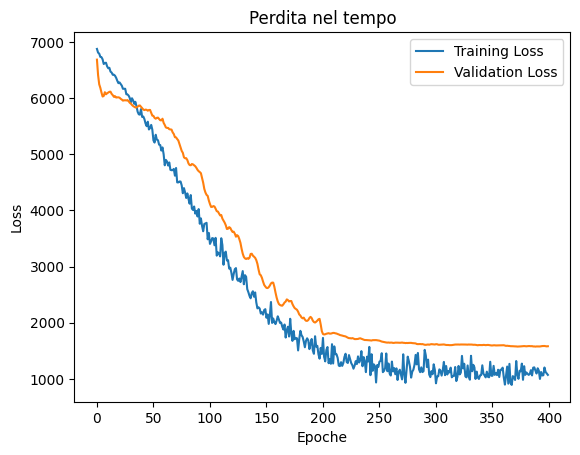

In [ ]:
# Visualizzazione della perdita (loss) nel tempo
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perdita nel tempo')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


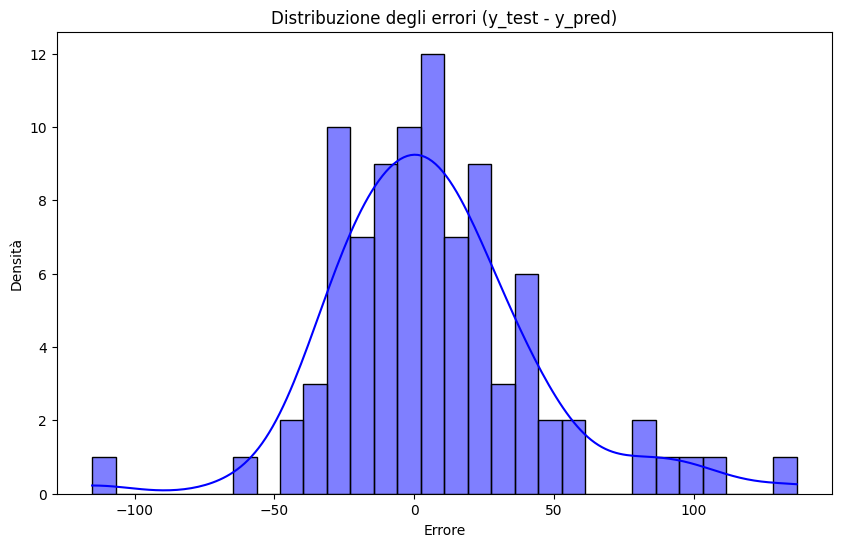

In [ ]:
# Fai le previsioni sui dati di test
y_pred = model.predict(X_test)

# Se y_pred ha due dimensioni (ad esempio: (77, 1)), lo appiattiamo in un array 1D
y_pred = y_pred.ravel()  # Oppure y_pred.flatten()

# Calcola gli errori (valori reali - previsioni)
errors = y_test - y_pred

# Visualizza la distribuzione degli errori
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True, color='blue')
plt.title("Distribuzione degli errori (y_test - y_pred)")
plt.xlabel("Errore")
plt.ylabel("Densità")
plt.show()

In [ ]:
# Dati del nuovo film come dizionario
new_film = {
    'TITOLO':"Il robot selvaggio",
    'mese': [10],
    'giorno': [7],
    'fascia_oraria': ['20'],
}

# Converti il nuovo film in un DataFrame
new_film_df = pd.DataFrame(new_film)
new_film_df=get_genre_ids(new_film_df)
new_film_df=get_movie_details(new_film_df)
new_film_df['collection_name'] = new_film_df['belongs_to_collection'].apply(extract_collection_name)
new_film_df['in_collection'] = new_film_df['belongs_to_collection'].apply(belongs_to_collection_binary)
#drop_col_new_film=["TITOLO","popularity","id","keywords","belongs_to_collection","collection_name"]
#new_film_df=new_film_df.drop(columns=drop_col_new_film)
new_film_df

,popularity,rating,in_collection,10402,10749,10751,10752,10770,12,14,...,original_language_ko,original_language_no,original_language_ru,original_language_uk,original_language_zh,fascia_oraria_8,fascia_oraria_17,fascia_oraria_20,director_encoded,production_company_encoded
0,8.298,7.418,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Step 1: Converti 'genre_ids' in stringhe
new_film_df['genre_ids'] = new_film_df['genre_ids'].astype(str)
new_film_df["cast"]=new_film_df["cast"].astype("str") #casto il cast a str
new_film_encoded = pd.get_dummies(new_film_df, columns=cat_col)

# Step 2: Allinea le colonne del nuovo film con quelle del dataset di training
# Riempie le colonne mancanti con 0 per evitare errori durante la previsione
new_film_encoded = new_film_encoded.reindex(columns=X_train.columns, fill_value=0)

# Step 3: Standardizzazione delle variabili numeriche
new_film_encoded[num_col] = scaler.transform(new_film_encoded[num_col])

# Step 4: Prevedere il risultato con il modello addestrato
prediction = model.predict(new_film_encoded)

# Stampa la previsione
print(f"La previsione per il nuovo film è: {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
La previsione per il nuovo film è: [37.13215]


nuovo preprocessing per predizione

In [ ]:
# Prepara il nuovo film come DataFrame
new_film = {
    'TITOLO': "Il regno del pianeta delle scimmio",
    'mese': [6],
    'giorno': [6],
    'fascia_oraria': ['20'],
}
new_film_df = pd.DataFrame(new_film)

# Esegui preprocessing specifico per il film
new_film_df = get_genre_ids(new_film_df)
new_film_df = get_movie_details(new_film_df)
new_film_df['collection_name'] = new_film_df['belongs_to_collection'].apply(extract_collection_name)
new_film_df['in_collection'] = new_film_df['belongs_to_collection'].apply(belongs_to_collection_binary)

# Estrarre i primi due generi come stringhe
new_film_df['main_genre'] = new_film_df['genre_ids'].apply(lambda x: str(x[0]) if len(x) > 0 else None)
new_film_df['secondary_genre'] = new_film_df['genre_ids'].apply(lambda x: str(x[1]) if len(x) > 1 else None)

# Concatena main_genre e secondary_genre
new_film_df['all_genres'] = new_film_df[['main_genre', 'secondary_genre']].apply(lambda x: ','.join([str(i) for i in x if pd.notnull(i)]), axis=1)
# Applica One-Hot Encoding
mlb = MultiLabelBinarizer()

genres_encoded = pd.DataFrame(mlb.fit_transform(new_film_df['all_genres'].str.split(',')), columns=mlb.classes_, index=new_film_df.index)
# Aggiungi le colonne al dataframe
new_film_df = pd.concat([new_film_df, genres_encoded], axis=1)

# Rimuovi colonne non necessarie
drop_columns = ['TITOLO', 'id', 'keywords', 'belongs_to_collection', 'collection_name',
                'main_genre', 'secondary_genre', 'all_genres']
new_film_df = new_film_df.drop(columns=drop_columns)

# Codifica ciclica per mese e giorno
new_film_df['mese_sin'] = np.sin(2 * np.pi * new_film_df['mese'] / 12)
new_film_df['mese_cos'] = np.cos(2 * np.pi * new_film_df['mese'] / 12)
new_film_df['giorno_sin'] = np.sin(2 * np.pi * new_film_df['giorno'] / 31)
new_film_df['giorno_cos'] = np.cos(2 * np.pi * new_film_df['giorno'] / 31)
new_film_df = new_film_df.drop(columns=['mese', 'giorno'])

# One-Hot Encoding per lingua e fascia oraria
new_film_df = pd.get_dummies(new_film_df, columns=['original_language', 'fascia_oraria'], drop_first=False)

#NUMERICAL
# Colonne numeriche da scalare (devono corrispondere a quelle usate nell'addestramento)
num_col = ['rating', 'popularity']
# Aggiungi un offset se necessario (come nell'addestramento)
for col in num_col:
    if col in new_film_df.columns:
        min_value = X_train[col].min()  # Usa il minimo di X_train
        if min_value <= 0:
            offset = 1 - min_value
            new_film_df[col] += offset
# Applica lo scaler utilizzato nell'addestramento
new_film_df[num_col] = scaler.transform(new_film_df[num_col])

# Aggiungi le colonne mancanti e ordina come X_train
new_film_df = new_film_df.reindex(columns=X_train.columns, fill_value=0)

# Rimuovi eventuali colonne duplicate e ordina
new_film_df = new_film_df.loc[:, ~new_film_df.columns.duplicated()]

# Mostra il risultato
new_film_df

,popularity,rating,in_collection,10402,10749,10751,10752,10770,12,14,...,original_language_ko,original_language_no,original_language_ru,original_language_uk,original_language_zh,fascia_oraria_8,fascia_oraria_17,fascia_oraria_20,director_encoded,production_company_encoded
0,1.420092,6.835915,True,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,True,0,0


In [ ]:
#prediction
# Ora il nuovo film è pronto per la predizione
prediction = model.predict(new_film_df)
print(f"Predizione del totale spettatori: {prediction[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predizione del totale spettatori: 22.118825912475586


In [ ]:
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers

# Step 1: Apply PCA to Reduce Features
def apply_pca(X_train, X_val, X_test, variance_ratio=0.90):
    # Define the PCA model, maintaining the given variance ratio
    pca = PCA(n_components=variance_ratio)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)

    print(f"Number of components selected: {pca.n_components_}")
    return X_train_pca, X_val_pca, X_test_pca

# Step 2: Define Neural Network Architecture
def create_network(input_dim, neurons_1layer=256, neurons_2layer=128, neurons_3layer=64, activation_function='relu'):
    # Input Layer
    inputs = tf.keras.Input(shape=(input_dim,))

    # Hidden Layers
    x = layers.Dense(neurons_1layer, activation=activation_function)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(neurons_2layer, activation=activation_function)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(neurons_3layer, activation=activation_function)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    # Output Layer (for regression)
    outputs = layers.Dense(1)(x)

    # Model Definition
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Step 3: Prepare Dataset
def prepare_dataset(df, target_column='tot', cat_col=["mese", "giorno", "genre_ids", "original_language", "director", "production_company", 'fascia_oraria', 'in_collection'], num_col=["budget"]):
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    X_encoded = pd.get_dummies(X, columns=cat_col)

    X_train_val, X_test, y_train_val, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    scaler = PowerTransformer(method='box-cox')
    X_train[num_col] = scaler.fit_transform(X_train[num_col])
    X_val[num_col] = scaler.transform(X_val[num_col])
    X_test[num_col] = scaler.transform(X_test[num_col])

    # Verifica delle dimensioni finali
    print(f"Dimensione X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Dimensione X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"Dimensione X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Step 4: Train the Model
def train_model(X_train_pca, X_val_pca, y_train, y_val):
    input_dim = X_train_pca.shape[1]
    model = create_network(input_dim)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
    history = model.fit(X_train_pca, y_train, epochs=500, batch_size=16, validation_data=(X_val_pca, y_val), callbacks=[early_stopping, reduce_lr])

    return model, history

# Step 5: Evaluate the Model
def evaluate_model(model, X_test_pca, y_test):
    test_loss, test_mae = model.evaluate(X_test_pca, y_test)
    print(f"Test loss (MSE): {test_loss}")
    print(f"Test MAE: {test_mae}")

# Example Usage
# Assume df is your dataframe loaded from somewhere
df = df2  # Use the updated df2 with movie data

# Preparing dataset
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(df)

# Apply PCA
X_train_pca, X_val_pca, X_test_pca = apply_pca(X_train, X_val, X_test)

# Train Model
model, history = train_model(X_train_pca, X_val_pca, y_train, y_val)

# Evaluate Model
evaluate_model(model, X_test_pca, y_test)

# Plot Training History
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


KeyError: "['mese', 'giorno', 'genre_ids', 'original_language', 'fascia_oraria'] not in index"